# Automatización de la extracción de datos financieros para acciones
## Introduccion

**Contexto de Negocio.** Recientemente se ha unido a la división de ciencia de datos de un banco multinacional. Durante el último mes, ha estado trabajando con una variedad de datos de acciones y está buscando recopilar datos fundamentales sobre un grupo selecto de acciones de energía. Su empresa está específicamente interesada en realizar inversiones en una de las siguientes cinco empresas del sector energético:

1. Dominion Energy Inc. (Stock Symbol: D)
2. Exelon Corp. (Stock Symbol: EXC)
3. NextEra Energy Inc. (Stock Symbol: NEE)
4. Southern Co. (Stock Symbol: SO)
5. Duke Energy Corp. (Stock Symbol: DUK)

Su empresa quiere que recopile información sobre las ganancias por acción (EPS) de cada acción, la relación precio-ganancias (relación PE) y los datos de capitalización de mercado para tomar su decisión de inversión. Sin embargo, la empresa no tiene experiencia en hacer esto de manera automatizada, sino que hasta este momento depende del trabajo manual que consume mucho tiempo.

**Problema de negocio.** Su jefe le ha hecho la siguiente pregunta: **"¿Cómo podemos automatizar la recopilación de ganancias por acción (EPS), la relación precio-ganancias (relación PE) y los datos de capitalización de mercado?"**

**Contexto analitico.**  En este caso, aprenderan la habilidad clave de **web scraping**: la práctica de tomar automáticamente información de las páginas web en línea, luego analizar y transformar esa información en un formato susceptible de análisis adicional.

La estructura que tendremos es: (1) aprenderá los conceptos básicos de HTML, que gobierna casi todas las páginas web estáticas; (2) analizar un documento HTML de muestra; (3) extraer la información necesaria del documento HTML de una sola acción; (4) escale este proceso a todos los símbolos; y (5) aprender a extraer el contenido de un documento HTML de una página web en vivo en tiempo real.

In [1]:
!python3 -m pip install bs4
!pip3 show bs4

Defaulting to user installation because normal site-packages is not writeable
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
  Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Name: bs4
Version: 0.0.2
Summary: Dummy package for Beautiful Soup (beautifulsoup4)
Home-page: 
Author: 
Author-email: Leonard Richardson <leonardr@segfault.org>
License: MIT License
Location: /Users/davidusta/Library/Python/3.9/lib/python/site-packages
Requires: beautifulsoup4
Required-by: 


In [2]:
# Paquetes basicos para web-scraping
from IPython.core.display import HTML
from bs4 import BeautifulSoup
from IPython.display import IFrame
import urllib # paquete para interactuar con una pagina en vivo
import pandas as pd # almacenar la info de la pagina web

## Conceptos basicos de Hyper Text Markup Language (HTML)

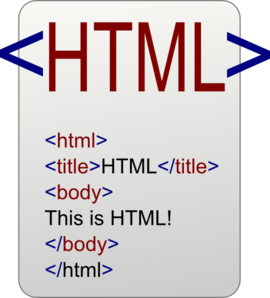

Para automatizar la extracción y el procesamiento de datos de existencias, debe familiarizarse con el lenguaje de marcado de hipertexto (HTML). HTML es un lenguaje de marcado para crear páginas web y aplicaciones; usualmente tu interactúas con HTML constantemente mientras navegas por la web, ya que la gran mayoría de las páginas están escritas con HTML. Algunos puntos importantes a tener en cuenta al repasar los conceptos básicos de HTML:

1. El HTML se utiliza tradicionalmente para diseñar páginas web estáticas (es decir, no interactivas).
2. HTML utiliza una estructura de datos anidada con etiquetas para indicar a los navegadores cómo mostrar el contenido.
3. HTML es independiente de la plataforma
4. HTML se puede integrar en otros idiomas (por ejemplo, JavaScript)
5. Se puede crear HTML con cualquier editor de texto.

Un documento HTML se compone de una serie de etiquetas. Estas etiquetas instruyen al navegador sobre cómo mostrar contenido al usuario. Diferentes etiquetas harán que se muestren diferentes estilos de salida.

Comencemos discutiendo una cadena con formato HTML simple, ```custom_html_doc```.

In [3]:
custom_html_doc = """
<html>
<head>
<title>HTML Page Title</title>
</head>
<h1>Head: Important Header: Global News</h1>
<br>
<h2>Head: Less Imporant Header: Global News</h2>
<body>
<p class="title"><b>Paragraph: Financial news</b></p>
<p class="story"> Stocks had a volatile week, where
<a href="https://finance.yahoo.com/quote/duk/" target="_blank" class="stock" id="link1">DUK</a>,
<a href="https://finance.yahoo.com/quote/d/" target="_blank" class="stock" id="link2">D</a>,
<a href="https://finance.yahoo.com/quote/exc/" target="_blank" class="stock" id="link3">EXC</a>,
<a href="https://finance.yahoo.com/quote/nee/" target="_blank" class="etf" id="link4">NEE</a>,
<a href="https://finance.yahoo.com/quote/so/" target="_blank" class="stock" id="link5">SO</a>,
were all making headlines.</p>
<p class="details">End of HTML document.</p>
</html>
"""

Si bien hay una gran cantidad de etiquetas disponibles en HTML, el ejemplo anterior destaca los fundamentos que necesitamos para comenzar con el lenguaje. Las cuatro etiquetas vitales de cualquier documento HTML incluyen:

1. < html> Indica al navegador que su página web está en formato HTML.
2. < head > Esta es información que puede ser utilizada por fuentes externas (como motores de búsqueda). Contiene metadatos de la página web.
3. < title > Los espectadores ven el título en la barra de herramientas del navegador, cuando la página se agrega a favoritos y en los resultados del motor de búsqueda.
4. < body > Define el bloque del cuerpo, que contiene el contenido de la página, incluidos el texto y las imágenes.


Otras etiquetas estructuralmente útiles incluyen:

1. < p > Define un bloque de párrafo que contiene principalmente texto que se mostrará al usuario
2. < a > Define un hipervínculo
3. < h1 > Define un encabezado importante
4. < h2 > Defina un encabezado menos importante
5. < br > Definir un salto de línea

Podemos ver como nuestro ```custom_html_doc``` hara el proceso de render usando el metodo ```HTML()```:

In [4]:
# Mirar el HTML asi como apareceria en un navegador
HTML(custom_html_doc)

Vemos que la etiqueta de encabezado < h1 > más importante es responsable del texto en negrita más grande del documento. Además, las etiquetas de párrafo hacen que el texto anidado entre sus etiquetas se muestre en una fuente de tamaño normal y sin negrita. Las etiquetas de hipervínculo introducen los enlaces del sitio web para cada símbolo bursátil (DUK, D, etc.).

### Ejercicio 1:

¿Todas las etiquetas de un documento HTML requieren una etiqueta de cierre?

(a) Sí, todas las etiquetas deben terminarse para que el navegador muestre correctamente la página web.

(b) No, hay algunas etiquetas en HTML que no requieren una etiqueta final.

**Respuesta** (b). Si bien la mayoría de las etiquetas en HTML tienen etiquetas finales, algunas no las tienen. Por ejemplo, la etiqueta de salto de línea < br > no tiene etiqueta final.

### Ejercicio 2:

Se encontró el siguiente documento HTML sin todas sus etiquetas finales. De arriba a abajo, determine el orden correcto en el que se deben agregar las etiquetas finales para eliminar los problemas con el documento.

```
<h1>This is a Heading
<p>This is a paragraph.
<br>
<p>Another paragraph
<br>
```

(a) < /h1 >, < /p >, < /br >, < /p >

(b) < /h1 >, < /p >,  < /br >, < /p >, < /br >

(c) < /h1 >, < /p >, < /p >

(d) < /h1 >, < /p >



**Respuesta.** (c). El documento podra funcionar en la siguiente forma:
```
<h1>This is a Heading</h1>
<p>This is a paragraph.</p>
<br>
<p>Another paragraph</p>
<br>
```
 (c) los tags correctos son < /h1 >, < /p >, and < /p > en el orden respectivo . Recuerden que los tags < br > tags no necesitan un tag final por eso no pueden estar en la respuesta. La repsuesta (d) es incorrecta es incorrecta ya que falta la segunda etiqueta < p > final.


Ahora que hemos cubierto los conceptos básicos de un documento HTML, avancemos y analicemos los métodos para cargar y extraer información de documentos HTML en Python. Afortunadamente, Python ofrece el paquete ```BeautifulSoup``` para ayudar con esta tarea.

## Usando ```BeautifulSoup``` para navegar en el documento HTML

```BeautifulSoup``` transforma un documento HTML en una estructura de árbol navegable. Esto es importante y útil para hacer que los documentos HTML se puedan programar y analizar automáticamente. El propósito principal de ```BeautifulSoup``` es facilitar considerablemente el trabajo con documentos HTML. Específicamente, ```BeautifulSoup``` es una biblioteca en Python que se encuentra en la parte superior de HTML y:

1. Ofrece una variedad de formas de buscar en el documento HTML.
2. Le permite editar el documento HTML.
3. Ofrece técnicas para extraer información de un documento HTML.

Comencemos con ```BeautifulSoup``` para analizar el ```custom_html_doc```.

## Parsing del documento HTML

En ```BeautifulSoup```, las etiquetas corresponden a la etiqueta HTML en el documento HTML original. El ```html.parser``` de la biblioteca ```BeautifulSoup``` es la opción estándar para analizar una cadena con formato HTML simple. También usaremos el método ```prettify()``` para mostrar la cadena HTML analizada con sangrías incluidas, que ilustra cómo ```BeautifulSoup``` ve el documento HTML, como una jerarquía de etiquetas de estructura de árbol:

In [5]:
custom_html_doc

'\n<html>\n<head>\n<title>HTML Page Title</title>\n</head>\n<h1>Head: Important Header: Global News</h1>\n<br>\n<h2>Head: Less Imporant Header: Global News</h2>\n<body>\n<p class="title"><b>Paragraph: Financial news</b></p>\n<p class="story"> Stocks had a volatile week, where\n<a href="https://finance.yahoo.com/quote/duk/" target="_blank" class="stock" id="link1">DUK</a>,\n<a href="https://finance.yahoo.com/quote/d/" target="_blank" class="stock" id="link2">D</a>,\n<a href="https://finance.yahoo.com/quote/exc/" target="_blank" class="stock" id="link3">EXC</a>,\n<a href="https://finance.yahoo.com/quote/nee/" target="_blank" class="etf" id="link4">NEE</a>,\n<a href="https://finance.yahoo.com/quote/so/" target="_blank" class="stock" id="link5">SO</a>,\nwere all making headlines.</p>\n<p class="details">End of HTML document.</p>\n</html>\n'

In [6]:
# Usando el standard html.parser para convertir el documento HTML en una estrcutura BeautifulSoup
soup = BeautifulSoup(custom_html_doc, 'html.parser')
# Imprimir el HTML con la identacion incluida 
print(soup.prettify())

<html>
 <head>
  <title>
   HTML Page Title
  </title>
 </head>
 <h1>
  Head: Important Header: Global News
 </h1>
 <br/>
 <h2>
  Head: Less Imporant Header: Global News
 </h2>
 <body>
  <p class="title">
   <b>
    Paragraph: Financial news
   </b>
  </p>
  <p class="story">
   Stocks had a volatile week, where
   <a class="stock" href="https://finance.yahoo.com/quote/duk/" id="link1" target="_blank">
    DUK
   </a>
   ,
   <a class="stock" href="https://finance.yahoo.com/quote/d/" id="link2" target="_blank">
    D
   </a>
   ,
   <a class="stock" href="https://finance.yahoo.com/quote/exc/" id="link3" target="_blank">
    EXC
   </a>
   ,
   <a class="etf" href="https://finance.yahoo.com/quote/nee/" id="link4" target="_blank">
    NEE
   </a>
   ,
   <a class="stock" href="https://finance.yahoo.com/quote/so/" id="link5" target="_blank">
    SO
   </a>
   ,
were all making headlines.
  </p>
  <p class="details">
   End of HTML document.
  </p>
 </body>
</html>



In [7]:
type(soup)

bs4.BeautifulSoup

Aquí vemos que ```BeautifulSoup``` se ha leído completamente en la cadena del documento HTML ```custom_html_doc```. Echemos un vistazo a algunas de las características básicas de ```BeautifulSoup``` para ver el contenido dentro de ```soup```.

Primero, podemos seleccionar etiquetas por nombre usando el ```.``` seguido del nombre de la etiqueta:


In [10]:
# Extraer tag h1
h1s= soup.h1
h1s.contents

['Head: Important Header: Global News']

In [11]:
# Seleccionemos primeros los tags 'a' ten soup (de forma predeterminada, se selecciona la primera aparición de una etiqueta)
tag = soup.a
# Imprimir el tag
print(tag)

<a class="stock" href="https://finance.yahoo.com/quote/duk/" id="link1" target="_blank">DUK</a>


In [12]:
# Mostrar el tipo de tag 
type(tag)

bs4.element.Tag

Observe cómo la ```tag``` anterior tiene el tipo ```bs4.element.Tag```. Este es el objeto dentro del cual ```BeautifulSoup``` almacena las etiquetas.

Las etiquetas ```BeautifulSoup``` tienen atributos y métodos. Los atributos son esencialmente propiedades del objeto de etiqueta, mientras que los métodos son formas de llamar a funciones en el objeto de etiqueta. Echemos un vistazo a un ejemplo de un atributo:

In [13]:
# # Noten que cada tag tiene un nombre
# print(tag.name)

Es importante destacar que las etiquetas pueden tener varios atributos. Podemos acceder a los atributos de una etiqueta usando la propiedad ```attrs``` de la etiqueta.

In [14]:
# # Mostrar todos los atributos del tag
# print(tag.attrs)

In [15]:
# # Acceda al atributo de hipervínculo (use una etiqueta como un diccionario para acceder) 
# print(tag['href'])

In [16]:
# # Adicionar un nuevo atributo (modificar el soup)
# tag['new_attr'] = 100

# # Mirar resultados
# print(tag.attrs)

## Extraer todos los tags de cierto tipo desde un archivo HTML

Como vimos anteriormente, si simplemente usamos ```soup.tag_name```, para algún tag_name de interés, como una etiqueta de hipervínculo ```a```, solo recibimos la primera etiqueta. ¿Cómo recibimos todas las etiquetas en un documento de cierto tipo?

Afortunadamente, ```BeautifulSoup``` ofrece la capacidad de navegar por su estructura de datos a través de una variedad de métodos de búsqueda. El que devuelve todas las etiquetas de un tipo determinado es ```find_all()```:

In [17]:
# Ver todos los tags de hyperlink en el custom_html_doc
soup.find_all('a')

[<a class="stock" href="https://finance.yahoo.com/quote/duk/" id="link1" target="_blank">DUK</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/d/" id="link2" target="_blank">D</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/exc/" id="link3" target="_blank">EXC</a>,
 <a class="etf" href="https://finance.yahoo.com/quote/nee/" id="link4" target="_blank">NEE</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/so/" id="link5" target="_blank">SO</a>]

In [18]:
soup.find_all('p')

[<p class="title"><b>Paragraph: Financial news</b></p>,
 <p class="story"> Stocks had a volatile week, where
 <a class="stock" href="https://finance.yahoo.com/quote/duk/" id="link1" target="_blank">DUK</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/d/" id="link2" target="_blank">D</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/exc/" id="link3" target="_blank">EXC</a>,
 <a class="etf" href="https://finance.yahoo.com/quote/nee/" id="link4" target="_blank">NEE</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/so/" id="link5" target="_blank">SO</a>,
 were all making headlines.</p>,
 <p class="details">End of HTML document.</p>]

In [19]:
soup.find_all('h1')

[<h1>Head: Important Header: Global News</h1>]

In [20]:
soup.find_all('h2')

[<h2>Head: Less Imporant Header: Global News</h2>]

In [21]:
soup.find_all('body')

[<body>
 <p class="title"><b>Paragraph: Financial news</b></p>
 <p class="story"> Stocks had a volatile week, where
 <a class="stock" href="https://finance.yahoo.com/quote/duk/" id="link1" target="_blank">DUK</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/d/" id="link2" target="_blank">D</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/exc/" id="link3" target="_blank">EXC</a>,
 <a class="etf" href="https://finance.yahoo.com/quote/nee/" id="link4" target="_blank">NEE</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/so/" id="link5" target="_blank">SO</a>,
 were all making headlines.</p>
 <p class="details">End of HTML document.</p>
 </body>]

### Ejercicio 3:

Escriba un script para imprimir todos los hipervínculos presentes en ```soup```.

In [22]:
soup.find_all("a")

[<a class="stock" href="https://finance.yahoo.com/quote/duk/" id="link1" target="_blank">DUK</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/d/" id="link2" target="_blank">D</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/exc/" id="link3" target="_blank">EXC</a>,
 <a class="etf" href="https://finance.yahoo.com/quote/nee/" id="link4" target="_blank">NEE</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/so/" id="link5" target="_blank">SO</a>]

In [23]:
[x['href'] for x in soup.find_all('a')]

['https://finance.yahoo.com/quote/duk/',
 'https://finance.yahoo.com/quote/d/',
 'https://finance.yahoo.com/quote/exc/',
 'https://finance.yahoo.com/quote/nee/',
 'https://finance.yahoo.com/quote/so/']

In [96]:
for tag in soup.find_all('a'):
    print(tag['href'])

https://finance.yahoo.com/quote/duk/
https://finance.yahoo.com/quote/d/
https://finance.yahoo.com/quote/exc/
https://finance.yahoo.com/quote/nee/
https://finance.yahoo.com/quote/so/


In [97]:
for tag in soup.find_all('a'):
    print(tag['id'])

link1
link2
link3
link4
link5


In [98]:
[x['id'] for x in soup.find_all('a')]

['link1', 'link2', 'link3', 'link4', 'link5']

Tenga en cuenta que esta estructura ```BeautifulSoup``` simplifica enormemente el análisis de un documento HTML. La estructura ha sido codificada en una estructura navegable simple, donde hay operaciones para acceder a cada subparte del documento completo.


In [28]:
custom_html_doc

'\n<html>\n<head>\n<title>HTML Page Title</title>\n</head>\n<h1>Head: Important Header: Global News</h1>\n<br>\n<h2>Head: Less Imporant Header: Global News</h2>\n<body>\n<p class="title"><b>Paragraph: Financial news</b></p>\n<p class="story"> Stocks had a volatile week, where\n<a href="https://finance.yahoo.com/quote/duk/" target="_blank" class="stock" id="link1">DUK</a>,\n<a href="https://finance.yahoo.com/quote/d/" target="_blank" class="stock" id="link2">D</a>,\n<a href="https://finance.yahoo.com/quote/exc/" target="_blank" class="stock" id="link3">EXC</a>,\n<a href="https://finance.yahoo.com/quote/nee/" target="_blank" class="etf" id="link4">NEE</a>,\n<a href="https://finance.yahoo.com/quote/so/" target="_blank" class="stock" id="link5">SO</a>,\nwere all making headlines.</p>\n<p class="details">End of HTML document.</p>\n</html>\n'

### Ejercicio 4:

Desde el ```custom_html_doc``` anterior, use ```BeautifulSoup``` para imprimir el símbolo, la clase y los atributos href para todas las etiquetas < a >. Por ejemplo, la primera línea de salida debería imprimirse:

```python
AAPL,stock,https://finance.yahoo.com/quote/aapl/
```

**Respuesta.**

In [99]:
# s = BeautifulSoup(custom_html_doc, 'html.parser')
# a_tag_list = s.find_all('a')
# a_tag_list

[<a class="stock" href="https://finance.yahoo.com/quote/duk/" id="link1" target="_blank">DUK</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/d/" id="link2" target="_blank">D</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/exc/" id="link3" target="_blank">EXC</a>,
 <a class="etf" href="https://finance.yahoo.com/quote/nee/" id="link4" target="_blank">NEE</a>,
 <a class="stock" href="https://finance.yahoo.com/quote/so/" id="link5" target="_blank">SO</a>]

In [24]:
# # Loop en cada uno de los tags
# for tag in a_tag_list:
#     symbol_name = tag.text
#     class_name = tag['class'][0]
#     #print(class_name)
#     href_name = tag['href']
#     print(symbol_name + ',' + class_name + ',' + href_name)

## Procesando un documento de HTML de una pagina web real

Recuerde que estamos interesados en extraer datos fundamentales de las acciones de Yahoo! Financiamiento para facilitar la recomendación de acciones. Estamos específicamente interesados en las ganancias por acción (EPS), la proporción de PE y la capitalización de mercado de una empresa.

Hemos descargado previamente las paginas web de Yahoo! Financie y tambien hemos guardado los archivos HTML para cada uno de los cinco símbolos del sector energético en estudio. Primero nos centraremos en Duke Energy Corporation, un holding de energía eléctrica con el símbolo de acciones DUK. Rendericemos la página web en el cuaderno usando ```IFrame``` y echemos un vistazo a su contenido.

In [25]:
# Abrir el archivo file y pase el identificador del archivo (aquí el identificador del archivo es f) a BeautifulSoup
file_name = 'DUK_2.html'
with open(file_name, encoding='utf-8') as f:
    stock_soup = BeautifulSoup(f, 'html.parser')

In [26]:
# Extraer los primeros 1000 characters y mirar un head del documento (no quiero imprimir demasiado para no quedar desordenado)
print(stock_soup.prettify()[:500])

<!DOCTYPE html>
<html class="NoJs chrome desktop" data-color-theme="light" id="atomic" lang="en-US">
 <head prefix="og: https://ogp.me/ns#">
  <script>
   window.performance && window.performance.mark && window.performance.mark('PageStart');
  </script>
  <meta charset="utf-8"/>
  <title>
   Duke Energy Corporation (DUK) Stock Price, News, Quote &amp; History - Yahoo Finance
  </title>
  <meta content="DUK, Duke Energy Corporation, DUK stock chart, Duke Energy Corporation stock chart, stock char


In [27]:
# Extraer todo lo que sea table data (td)
stock_soup.find_all('td')

[<td class="C($primaryColor) W(51%)"><span>Previous Close</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="PREV_CLOSE-value">89.87</td>,
 <td class="C($primaryColor) W(51%)"><span>Open</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="OPEN-value">89.53</td>,
 <td class="C($primaryColor) W(51%)"><span>Bid</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="BID-value">87.37 x 3000</td>,
 <td class="C($primaryColor) W(51%)"><span>Ask</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="ASK-value">88.06 x 800</td>,
 <td class="C($primaryColor) W(51%)"><span>Day's Range</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="DAYS_RANGE-value">87.19 - 90.03</td>,
 <td class="C($primaryColor) W(51%)"><span>52 Week Range</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="FIFTY_TWO_WK_RANGE-value">83.06 - 106.43</td>,
 <td class="C($primaryColor) W(51%)"><span>Volume</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="TD_VOL

Vemos aquí que, si bien la estructura de una página web real es más compleja que nuestro documento de muestra anterior, aún conserva la misma estructura HTML que consta de una serie de etiquetas anidadas, cada una de las cuales identifica diferentes elementos del documento.

Una herramienta útil para depurar y verificar los componentes en un documento HTML es observar el número de ocurrencias de cada tipo de etiqueta en el documento.


### Ejercicio 5:

Escriba un script para determinar el número de apariciones de cada etiqueta en ```stock_soup```. Imprima en la pantalla un diccionario donde cada key es un nombre de etiqueta y el valor correspondiente para cada clave es el número de apariciones de esa etiqueta en particular.

**Respuesta.**

In [28]:
tag_list = []
for tag in stock_soup.find_all():
    tag_list.append(tag.name)
print(len(tag_list))
print(tag_list[0:20])

890
['html', 'head', 'script', 'meta', 'title', 'meta', 'meta', 'meta', 'meta', 'meta', 'meta', 'meta', 'meta', 'meta', 'link', 'link', 'link', 'link', 'link', 'link']


In [29]:
print(len(set(tag_list)))
print(set(tag_list))

36
{'ul', 'b', 'div', 'h3', 'i', 'html', 'form', 'head', 'table', 'label', 'img', 'iframe', 'td', 'li', 'meta', 'svg', 'tr', 'canvas', 'u', 'input', 'script', 'button', 'h1', 'tbody', 'span', 'body', 'link', 'nav', 'a', 'title', 'p', 'path', 'br', 'fin-streamer', 'section', 'style'}


In [30]:
tag_count_dict = {}
for tag_name in tag_list:
    if tag_name in tag_count_dict:
        tag_count_dict[tag_name] = tag_count_dict[tag_name] + 1
    else:
        tag_count_dict[tag_name] = 1
        
tag_count_dict

{'html': 1,
 'head': 1,
 'script': 87,
 'meta': 25,
 'title': 1,
 'link': 31,
 'style': 4,
 'body': 1,
 'div': 325,
 'nav': 4,
 'ul': 10,
 'li': 56,
 'a': 71,
 'svg': 18,
 'path': 18,
 'b': 3,
 'form': 2,
 'label': 1,
 'input': 4,
 'button': 16,
 'span': 88,
 'i': 5,
 'h3': 9,
 'br': 7,
 'fin-streamer': 29,
 'canvas': 7,
 'iframe': 1,
 'h1': 1,
 'section': 2,
 'table': 2,
 'tbody': 2,
 'tr': 16,
 'td': 32,
 'img': 4,
 'u': 3,
 'p': 3}

In [31]:
tag_count_dict.items()

dict_items([('html', 1), ('head', 1), ('script', 87), ('meta', 25), ('title', 1), ('link', 31), ('style', 4), ('body', 1), ('div', 325), ('nav', 4), ('ul', 10), ('li', 56), ('a', 71), ('svg', 18), ('path', 18), ('b', 3), ('form', 2), ('label', 1), ('input', 4), ('button', 16), ('span', 88), ('i', 5), ('h3', 9), ('br', 7), ('fin-streamer', 29), ('canvas', 7), ('iframe', 1), ('h1', 1), ('section', 2), ('table', 2), ('tbody', 2), ('tr', 16), ('td', 32), ('img', 4), ('u', 3), ('p', 3)])

In [32]:
sorted(tag_count_dict.items(),key=lambda x: x[1],reverse=True)

[('div', 325),
 ('span', 88),
 ('script', 87),
 ('a', 71),
 ('li', 56),
 ('td', 32),
 ('link', 31),
 ('fin-streamer', 29),
 ('meta', 25),
 ('svg', 18),
 ('path', 18),
 ('button', 16),
 ('tr', 16),
 ('ul', 10),
 ('h3', 9),
 ('br', 7),
 ('canvas', 7),
 ('i', 5),
 ('style', 4),
 ('nav', 4),
 ('input', 4),
 ('img', 4),
 ('b', 3),
 ('u', 3),
 ('p', 3),
 ('form', 2),
 ('section', 2),
 ('table', 2),
 ('tbody', 2),
 ('html', 1),
 ('head', 1),
 ('title', 1),
 ('body', 1),
 ('label', 1),
 ('iframe', 1),
 ('h1', 1)]

Esto se usa a menudo para diagnosticar componentes faltantes de una página web. Continuemos avanzando para extraer nuestra primera cantidad de datos fundamentales de interés: la capitalización de mercado.

**Vamos por aqui**

## Extraer el market capitalization del documento HTML

Al ver el documento HTML de las acciones de DUK, vemos que hay una tabla que contiene nuestros datos fundamentales de interés. En HTML, la etiqueta ```<td>```define una celda en una tabla. Como sabemos que los datos del mercado de valores se almacenan en una tabla en el documento HTML, elegimos mirar todas las etiquetas de celda de la tabla:

In [109]:
# Nos gustaría seleccionar específicamente la etiqueta que contiene la información de capitalización de mercado para DUK
stock_soup.find_all("td")

[<td class="C($primaryColor) W(51%)"><span>Previous Close</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="PREV_CLOSE-value">89.87</td>,
 <td class="C($primaryColor) W(51%)"><span>Open</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="OPEN-value">89.53</td>,
 <td class="C($primaryColor) W(51%)"><span>Bid</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="BID-value">87.37 x 3000</td>,
 <td class="C($primaryColor) W(51%)"><span>Ask</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="ASK-value">88.06 x 800</td>,
 <td class="C($primaryColor) W(51%)"><span>Day's Range</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="DAYS_RANGE-value">87.19 - 90.03</td>,
 <td class="C($primaryColor) W(51%)"><span>52 Week Range</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="FIFTY_TWO_WK_RANGE-value">83.06 - 106.43</td>,
 <td class="C($primaryColor) W(51%)"><span>Volume</span></td>,
 <td class="Ta(end) Fw(600) Lh(14px)" data-test="TD_VOL

In [37]:
# Entonces, tneemos que buscar necesitamos buscar por más de una etiqueta -> agregar otro identificador para buscar
#stock_soup.find("td", {"data-reactid":"81"}).text

Sin embargo, el valor de identificador de 81 es bastante arbitrario; ¡Solo sabríamos buscar esto si hubiéramos inspeccionado manualmente el documento de antemano! Una mejor manera es buscar usando el identificador ```data-test```:

In [110]:
# O de otra manera (más estable ya que data-reactid puede cambiar)
stock_soup.find("td", {"data-test" : 'MARKET_CAP-value'}).text

'67.845B'

In [111]:
stock_soup.find("td", {"data-test" : "EPS_RATIO-value"}).text

'4.67'

Aunque solo hubiéramos sabido el nombre exacto del identificador de capitalización de mercado al examinar el documento, es MUCHO más fácil de encontrar que el identificador ```data-reactid``` de 81. Específicamente, podríamos simplemente haber hecho un Ctrl + F busque en el documento HTML con la entrada y haya encontrado el identificador exacto ```MARKET_CAP-value``` bastante rápido.

Las diferentes páginas web nombran diferentes elementos de manera diferente, por lo que cualquier análisis de análisis deberá personalizarse para la estructura de un sitio web específico. Sin embargo, una vez que se establecen las reglas de una página web determinada, el análisis se vuelve mucho más fácil ya que puede emplear el poder de ```BeautifulSoup```.

Practiquemos la extracción de elementos básicos de un documento HTML:

### Ejercicio 6:

Escriba un script para imprimir todos los identificadores disponibles de ```data-test``` presentes en la tabla (es decir, presentes en la primera etiqueta td de ```stock_soup```). Su salida debería imprimirse así:

```
PREV_CLOSE-value
OPEN-value
BID-value
ASK-value
DAYS_RANGE-value
FIFTY_TWO_WK_RANGE-value
TD_VOLUME-value
AVERAGE_VOLUME_3MONTH-value
MARKET_CAP-value
BETA_3Y-value
PE_RATIO-value
EPS_RATIO-value
EARNINGS_DATE-value
DIVIDEND_AND_YIELD-value
EX_DIVIDEND_DATE-value
ONE_YEAR_TARGET_PRICE-value
```

**Respuesta** 

In [112]:
for i in stock_soup.find_all("td",{'class':['Ta(end)', 'Fw(b)', 'Lh(14px)']}):
    print(i.attrs['data-test'])

PREV_CLOSE-value
OPEN-value
BID-value
ASK-value
DAYS_RANGE-value
FIFTY_TWO_WK_RANGE-value
TD_VOLUME-value
AVERAGE_VOLUME_3MONTH-value
MARKET_CAP-value
BETA_5Y-value
PE_RATIO-value
EPS_RATIO-value
EARNINGS_DATE-value
DIVIDEND_AND_YIELD-value
EX_DIVIDEND_DATE-value
ONE_YEAR_TARGET_PRICE-value


### Ejercicio 7:
Imprima la oferta (Bid), la demanda (Ask), el volumen (Volume) y el volumen promedio (Average Volume) del símbolo bursátil DUK en ```DUK_Yahoo.html```.

**Respuesta.**

In [113]:
# Cargar el archivo
file_name = 'DUK_2.html'
with open(file_name,encoding='utf-8') as f:
    stock_soup = BeautifulSoup(f, 'html.parser')

# Mi codigo:
bid = stock_soup.find("td", {"data-test" : 'BID-value'}).text
ask = stock_soup.find("td", {"data-test" : 'ASK-value'}).text
volume = stock_soup.find("td", {"data-test" : 'TD_VOLUME-value'}).text
average_volume = stock_soup.find("td", {"data-test" : 'AVERAGE_VOLUME_3MONTH-value'}).text

print("Bid: ", bid)
print("Ask: ", ask)
print("Volume: ", volume)
print("Avg. Volume: ", average_volume)

Bid:  87.37 x 3000
Ask:  88.06 x 800
Volume:  3,156,248
Avg. Volume:  3,203,021


In [114]:
stock_soup.findAll("td", {"data-test":'ASK-value'})

[<td class="Ta(end) Fw(600) Lh(14px)" data-test="ASK-value">88.06 x 800</td>]

## Buscar y procesar multiples documentos HTML

Ahora nos gustaría automatizar la tarea de análisis anterior para los 5 símbolos. Nos gustaría crear una función que pueda analizar CUALQUIER símbolo bursátil utilizando un método sistemático para extraer información. Esta automatización acelerará el análisis de datos futuros y aumentará la productividad. Echemos un vistazo a cómo realizar esta tarea:

In [115]:
# Definir la lista de simbolos a buscar a los que queremos aplicarles el parse
symbol_list = ['NEE','DUK','D','SO','EXC']

In [116]:
def process_yahoo(symbol):
    # Cargar los archivos previamente guardados
    file_name = symbol + '_Yahoo.html'
    with open(file_name,encoding='utf-8') as f:
        s = BeautifulSoup(f, 'html.parser')
    
    # Analizar los datos de stock específicos de interés y almacenarlos en un objeto de diccionario 
    info_dict = {'MARKET_CAP' : s.find("td", {"data-test" : 'MARKET_CAP-value'}).text,
                 'ASK':  s.find("td", {"data-test" : 'ASK-value'}).text,
                 'TD_VOLUME': s.find("td", {"data-test" : 'TD_VOLUME-value'}).text,
                  'AVG_3M':s.find("td", {"data-test" : 'AVERAGE_VOLUME_3MONTH-value'}).text}
    
    return info_dict

# Recorra todos los símbolos, aplicando la función de análisis a cada uno de los archivos HTML correspondientes del símbolo.
fundamental_dict = {}
for sym in symbol_list:
    fundamental_dict[sym] = process_yahoo(sym)

In [117]:
fundamental_dict

{'NEE': {'MARKET_CAP': '83.98B',
  'ASK': '0.00 x 800',
  'TD_VOLUME': '2,215,013',
  'AVG_3M': '2,251,691'},
 'DUK': {'MARKET_CAP': '60.317B',
  'ASK': '84.80 x 800',
  'TD_VOLUME': '3,082,447',
  'AVG_3M': '3,855,570'},
 'D': {'MARKET_CAP': '52.519B',
  'ASK': '0.00 x 1800',
  'TD_VOLUME': '5,615,608',
  'AVG_3M': '4,591,043'},
 'SO': {'MARKET_CAP': '47.957B',
  'ASK': '0.00 x 900',
  'TD_VOLUME': '6,136,967',
  'AVG_3M': '6,080,853'},
 'EXC': {'MARKET_CAP': '44.279B',
  'ASK': '46.46 x 800',
  'TD_VOLUME': '4,782,737',
  'AVG_3M': '5,855,846'}}

In [118]:
import datetime
df= pd.DataFrame(fundamental_dict).T
df['date']= datetime.datetime.now()
nombre_= 'Data_'+str(datetime.datetime.now()) +'.csv'
df.to_csv(nombre_.replace(':','_').replace('-','_'),sep=',')
df

,MARKET_CAP,ASK,TD_VOLUME,AVG_3M,date
NEE,83.98B,0.00 x 800,"2,215,013","2,251,691",2024-08-27 20:25:34.361509
DUK,60.317B,84.80 x 800,"3,082,447","3,855,570",2024-08-27 20:25:34.361509
D,52.519B,0.00 x 1800,"5,615,608","4,591,043",2024-08-27 20:25:34.361509
SO,47.957B,0.00 x 900,"6,136,967","6,080,853",2024-08-27 20:25:34.361509
EXC,44.279B,46.46 x 800,"4,782,737","5,855,846",2024-08-27 20:25:34.361509


Aquí vemos que mediante el uso de una función, ahora podemos analizar sistemáticamente la información bursátil en busca de símbolos de nuestra elección. Esto tiene poderosas implicaciones para la eficiencia del análisis de datos posterior.


### Ejercicio 8:

Modificar la funcion ```process_yahoo()``` función para procesar y devolver las tres cantidades de datos fundamentales de interés, a saber, la capitalización de mercado, el índice de PE y el EPS. La función debe devolver un diccionario donde las claves son los identificadores ```data-test``` y los valores son los datos fundamentales correspondientes. Recorra todos los símbolos, aplicando la función de análisis sintáctico al archivo HTML correspondiente de cada símbolo e imprima cada diccionario de datos fundamentales en la pantalla.

**Respuesta.**

In [49]:
def process_yahoo(symbol):
    # Definir las variables de interes del mercado a buscar 
    MARKET_CAP= "MARKET_CAP"
    PE_RATIO = "PE_RATIO"
    EPS_RATIO = "EPS_RATIO"
    
    # Cargar previamente los archivos guardados 
    file_name = symbol + '_Yahoo.html'
    with open(file_name,encoding='utf-8') as f:
        s = BeautifulSoup(f, 'html.parser')
    
    # Analizar (Parse) los datos de stock específicos de interés y almacenarlos en un objeto de diccionario
    info_dict = {MARKET_CAP : s.find("td", {"data-test" : MARKET_CAP+'-value'}).text,
                 PE_RATIO : s.find("td", {"data-test" : PE_RATIO+'-value'}).text,
                 EPS_RATIO : s.find("td", {"data-test" : EPS_RATIO+'-value'}).text
                }
    
    return info_dict

# Recorrer todos los símbolos, aplicando la función de análisis a cada uno de los archivos HTML correspondientes del símbolo.
fundamental_dict = {}
for sym in symbol_list:
    fundamental_dict[sym] = process_yahoo(sym)
    
fundamental_dict

{'NEE': {'MARKET_CAP': '83.98B', 'PE_RATIO': '10.00', 'EPS_RATIO': '17.57'},
 'DUK': {'MARKET_CAP': '60.317B', 'PE_RATIO': '20.61', 'EPS_RATIO': '4.11'},
 'D': {'MARKET_CAP': '52.519B', 'PE_RATIO': '14.57', 'EPS_RATIO': '4.80'},
 'SO': {'MARKET_CAP': '47.957B', 'PE_RATIO': '19.45', 'EPS_RATIO': '2.40'},
 'EXC': {'MARKET_CAP': '44.279B', 'PE_RATIO': '11.91', 'EPS_RATIO': '3.84'}}

### Ejercicio 9:

Después de obtener los resultados preliminares con las tres cantidades de datos fundamentales de interés, su gerente le ha solicitado que agregue estadísticas adicionales para ayudar a determinar la liquidez de la acción en relación con su promedio. Esto ayudará a indicar si una acción se ha estado negociando a volúmenes más altos o más bajos recientemente. Escriba una función llamada ```scrape_volume_ratio``` que tome una cadena de nombre de símbolo como entrada y devuelva la relación de volumen, donde relación de volumen = volumen / volumen promedio. Todos los datos necesarios para calcular esta relación están disponibles en los documentos HTML para cada símbolo.

Ayudas:

1. Si necesita quitar las comas de una cadena, use el método replace() en esa cadena

2. Una vez que se eliminan las comas, puede cambiar una cadena a un flotador usando el método float()

Una vez que haya definido el bucle de función a través de todos los símbolos, aplique la función de análisis al archivo HTML correspondiente de cada símbolo. La salida resultante debería imprimir:

{'NEE': 0.9837109088236352,
 'DUK': 0.7994789356696934,
 'D': 1.2231660648789393,
 'SO': 1.0092279816663878,
 'EXC': 0.8167456931073666}

**Respuesta.**

In [50]:
def scrape_volume_ratio(symbol):
    VOLUME= "TD_VOLUME"
    AVG_VOLUME = "AVERAGE_VOLUME_3MONTH"
    # Cargar los archivos
    file_name = symbol + '_Yahoo.html'
    with open(file_name,encoding='utf-8') as f:
        s = BeautifulSoup(f, 'html.parser')
    # Parse
    info_dict = {VOLUME : s.find("td", {"data-test" : VOLUME+'-value'}).text,
                 AVG_VOLUME : s.find("td", {"data-test" : AVG_VOLUME+'-value'}).text,
                }
    # Procesar
    return float(info_dict[VOLUME].replace(',','')) / float(info_dict[AVG_VOLUME].replace(',',''))

volume_ratio_dict = {}
for sym in symbol_list:
    volume_ratio_dict[sym] = scrape_volume_ratio(sym)
    
volume_ratio_dict

{'NEE': 0.9837109088236352,
 'DUK': 0.7994789356696934,
 'D': 1.2231660648789393,
 'SO': 1.0092279816663878,
 'EXC': 0.8167456931073666}

Ahora que hemos extraído los datos fundamentales necesarios de nuestros documentos HTML guardados, echemos un vistazo rápido a cómo realizar el **webscrapping** en una página web en vivo en tiempo real.

## Live web scraping de data fundamental de stocks

**IMPORTANTE: debe tener cuidado de no ser bloqueado por un sitio web debido a un raspado excesivo. No ejecute un bucle que scrapes continuamente una página web o la página web le impedirá recibir datos debido a un exceso de mensajes.**

Exploremos el scrapping de datos de Yahoo! Página de finanzas. **(NOTA: NO ejecute este bloque de código ya que hacer que todos lo hagan a la vez puede hacer que se bloquee).**

In [51]:
# Abrir el archivo file y pase el identificador del archivo (aquí el identificador del archivo es f) a BeautifulSoup
file_name = 'DUKE_24092023.html'
with open(file_name, encoding='utf-8') as f:
    s = BeautifulSoup(f, 'html.parser')

In [52]:
# Mirar el objeto soup object con el  metodo prettify()
print(s.prettify()[:10000]) # Solo mostrar una porcion del texto ya que es largo 

<!DOCTYPE html>
<!-- saved from url=(0056)https://finance.yahoo.com/quote/DUK?p=DUK&.tsrc=fin-srch -->
<html class="chrome desktop JsEnabled themedark layoutEnhance(TwoColumnLayout) CollapsibleUh onDemandFocusSupport hasScrolled ShowNavrail scrollUp" data-color-theme="light" id="atomic" lang="en-US">
 <head prefix="og: https://ogp.me/ns#">
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script>
   window.performance && window.performance.mark && window.performance.mark('PageStart');
  </script>
  <title>
   Duke Energy Corporation (DUK) Stock Price, News, Quote &amp; History - Yahoo Finance
  </title>
  <meta content="DUK, Duke Energy Corporation, DUK stock chart, Duke Energy Corporation stock chart, stock chart, stocks, quotes, finance" name="keywords"/>
  <meta content="on" http-equiv="x-dns-prefetch-control"/>
  <meta content="on" property="twitter:dnt"/>
  <meta content="458584288257241" property="fb:app_id"/>
  <meta content="#400090" name="theme-color"/>

In [53]:
MARKET_CAP= "MARKET_CAP"
PE_RATIO = "PE_RATIO"
EPS_RATIO = "EPS_RATIO"
info_dict = {MARKET_CAP : s.find("td", {"data-test" : MARKET_CAP+'-value'}).text,
                 PE_RATIO : s.find("td", {"data-test" : PE_RATIO+'-value'}).text,
                 EPS_RATIO : s.find("td", {"data-test" : EPS_RATIO+'-value'}).text
                }
info_dict

{'MARKET_CAP': '71.93B', 'PE_RATIO': '19.99', 'EPS_RATIO': '4.67'}

$$\color{blue}{\textbf{\text{Ahora si quieres puedes hacer lo mismo para los demas simbolos}}}$$

1. Debes descargar todas las paginas web con los nombres `NEE.html`, `DUK.html`, `D.html`, `SO.html`, `EXC.html`
2. Y luego deberas ejecutar este codigo
3. El resultado sera un dataframe que se llama `fundamental_dict` con toda la data por accion

```python
symbol_list = ['NEE','DUK','D','SO','EXC'] # stocks

def scrape_yahoo(symbol):
    file_name = symbol
    with open(file_name, encoding='utf-8') as f:
        s = BeautifulSoup(f, 'html.parser')
    
    MARKET_CAP= "MARKET_CAP"
    PE_RATIO = "PE_RATIO"
    EPS_RATIO = "EPS_RATIO"
    
    info_dict = {MARKET_CAP : s.find("td", {"data-test" : MARKET_CAP+'-value'}).text,
                 PE_RATIO : s.find("td", {"data-test" : PE_RATIO+'-value'}).text,
                 EPS_RATIO : s.find("td", {"data-test" : EPS_RATIO+'-value'}).text
                }
    
    return info_dict

symbol_dict = {}
for symbol in symbol_list:
    print("Scraping Symbol: " + symbol)
    symbol_dict[symbol] = scrape_yahoo(symbol)

# Mostrar la data con parsing
fundamental_df = pd.DataFrame.from_dict(symbol_dict, orient='index')
fundamental_df
```


# Webscrapping live simple

In [ ]:
#!python3 -m pip install requests
!pip3 show requests

In [119]:
import requests
import os 
import warnings
warnings.filterwarnings("ignore")
os.getcwd()
url="https://finance.yahoo.com/quote/DUK?p=DUK&.tsrc=fin-srch"
response=requests.get(url)
with open("DUK_hoy.html","w",encoding="utf-8") as f:
    f.write(response.text)

In [120]:
file_name = 'DUK_hoy.html'
with open(file_name,encoding='utf-8') as f:
    stock_soup = BeautifulSoup(f, 'html.parser')
x=stock_soup.findAll("span")
x

[<span class="_yb_foz45s" tabindex="-1">New on Yahoo</span>,
 <span class="_yb_188hrwt _yb_1ydeg4p" tabindex="0"><svg fill="none" height="20" viewbox="0 0 20 20" width="20" xmlns="http://www.w3.org/2000/svg"><path d="M10.0011 10.6612L5.91234 6.57241C5.59699 6.25789 5.06949 6.25294 4.74754 6.57489C4.42228 6.90014 4.42393 7.41939 4.74506 7.73969L10.0011 12.9966L15.2588 7.73804C15.5742 7.42269 15.5791 6.89519 15.2564 6.57324C14.9319 6.24881 14.4127 6.24963 14.0916 6.57076L10.0011 10.6612Z" fill="#232A31"></path></svg></span>,
 <span><svg fill="none" height="13" viewbox="0 0 47 13" width="47" xmlns="http://www.w3.org/2000/svg"><path d="M13.5306 3.17798V3.85119C13.1441 3.34995 12.4282 3.00746 11.5992 3.00746C9.63976 3.00746 8.18013 4.73756 8.18013 6.76899C8.18013 8.85628 9.62506 10.5305 11.5992 10.5305C12.4282 10.5305 13.1441 10.2013 13.5306 9.67209V10.3439H15.9751V3.17798H13.5306ZM16.8189 0.00292478V10.3439H19.3515V6.52205C19.3515 5.77827 19.7087 5.33581 20.2805 5.33581C20.8523 5.33581 21.

In [125]:
strings =[str(y) for y in x]
[m for m in strings if "averageVolume" in m][0].split('>')[1].split(" ")[-1]
#[m for m in strings if "averageVolume" in m][0].split('>')[1].split(" ")[-1]

'data-value="2,898,593"'

In [128]:
u=[str(y.findAll('fin-streamer')) for y in x]
values=[m.replace('[','').replace(']','').split("data-value=")[1].split(">")[0] for m in u if m!='[]']

In [129]:
keys=[m.replace('[','').\
 replace(']','').\
    split("data-field=")[1].\
        split("data-symbol")[0].\
            strip().replace('"','') for m in u if m!='[]']

In [132]:
T=pd.DataFrame()
T["keys"]=keys
T["values"]=values
T.head(10)

,keys,values
0,regularMarketPreviousClose,"""113.01"""
1,regularMarketOpen,"""112.77"""
2,regularMarketDayRange,"""111.78 - 113.09"""
3,fiftyTwoWeekRange,"""83.06 - 116.67"""
4,regularMarketVolume,"""1,435,254"""
5,averageVolume,"""2,898,593"""
6,marketCap,"""86.409B"""
7,trailingPE,"""19.16"""
8,trailingPE,"""5.84"""
9,targetMeanPrice,"""116.98"""


In [116]:

"""
bid = stock_soup.find("td", {"data-test" : 'BID-value'}).text
ask = stock_soup.find("td", {"data-test" : 'ASK-value'}).text
volume = stock_soup.find("td", {"data-test" : 'TD_VOLUME-value'}).text
average_volume = stock_soup.find("td", {"data-test" : 'AVERAGE_VOLUME_3MONTH-value'}).text

print("Bid: ", bid)
print("Ask: ", ask)
print("Volume: ", volume)
print("Avg. Volume: ", average_volume)
"""

'\nbid = stock_soup.find("td", {"data-test" : \'BID-value\'}).text\nask = stock_soup.find("td", {"data-test" : \'ASK-value\'}).text\nvolume = stock_soup.find("td", {"data-test" : \'TD_VOLUME-value\'}).text\naverage_volume = stock_soup.find("td", {"data-test" : \'AVERAGE_VOLUME_3MONTH-value\'}).text\n\nprint("Bid: ", bid)\nprint("Ask: ", ask)\nprint("Volume: ", volume)\nprint("Avg. Volume: ", average_volume)\n'

## Conclusiones


En este caso, hemos introducido un marco para automatizar las tareas de raspado web para producir una recomendación de stock basada en datos fundamentales. Este marco general de raspado web se puede personalizar para abordar las necesidades únicas de un usuario en cuanto a requisitos de datos y requisitos de análisis.

Descubrimos que el raspado web del documento HTML para los cinco símbolos del sector energético requería un análisis de la estructura y el contenido de los documentos HTML para analizar las tres cantidades de datos fundamentales de interés: capitalización de mercado, índice de PE y EPS. Utilizamos estas tres estadísticas junto con los objetivos de inversión de la empresa para llegar a una recomendación para invertir en acciones NEE.